In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm, tnrange
from google.colab import drive

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200

# AE Arch

In [56]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Encoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Encoder, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(64*64*3, 256), nn.PReLU())
        self.linear2 = nn.Sequential(nn.Linear(256, 512), nn.PReLU())
        self.linear3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [57]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Decoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Sequential(nn.Linear(latent_dims, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, 64*64*3)

    def forward(self, z):
        z = self.linear1(z)
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

In [58]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# AE Training

In [50]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tnrange(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

# Date Loading

In [51]:
!ls

drive  sample_data


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
latent_dims = 512
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('/content/drive/MyDrive/custom_cartoons',
               transform=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()]),
        ),
        batch_size=32,
        shuffle=True)

autoencoder = train(autoencoder, data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [53]:
z = torch.rand((1, 512)).to(device)

In [54]:
res = autoencoder.decoder(z)

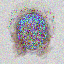

In [55]:
torchvision.transforms.ToPILImage()(res[0])

# VAE

In [41]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        """
        Implement Variational Encoder, use whatever you want
        """
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(64*64*3, 512)
        self.linear2 = nn.Linear(512, latent_dims) # mu
        self.linear3 = nn.Linear(512, latent_dims) # sigma

        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma * self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [35]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [36]:
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tnrange(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [42]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train_vae(vae, data)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [44]:
x, y = next(data.__iter__()) 
x_1 = x[0].unsqueeze(0).to(device) 
x_2 = x[1].unsqueeze(0).to(device) 

# Compare AE and VAE Interpolations
- Which is better? 
- Why? 
- Ответ буду читац глазами, лучше подкрепить картинками и объяснениями

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


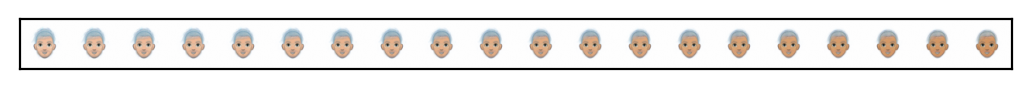

In [45]:
interpolate(vae, x_1, x_2, n=20)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


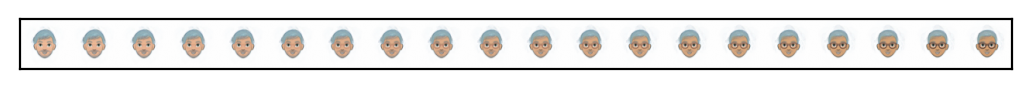

In [46]:
interpolate(autoencoder, x_1, x_2, n=20)
